# Taxi Order Forecasting

The company "Cool Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. The goal of the project is to build a model for such prediction.

The RMSE (Root Mean Squared Error) metric on the test set should not exceed 48.

The data is stored in the "taxi.csv" file. The number of orders is in the "num_orders" column.

## Preliminary Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     TimeSeriesSplit, 
                                     train_test_split
)                                     
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor

RANDOM_STATE = 12345

In [2]:
df = pd.read_csv('/Users/mojseenkodenis/Desktop/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
df = df.set_index('datetime')

In [8]:
#Resampling the data to one hour intervals
df = df.resample('1H').sum()

In [9]:
#Check if the data is in chronological order
df.index.is_monotonic

True

In [10]:
df.isnull().sum()

num_orders    0
dtype: int64

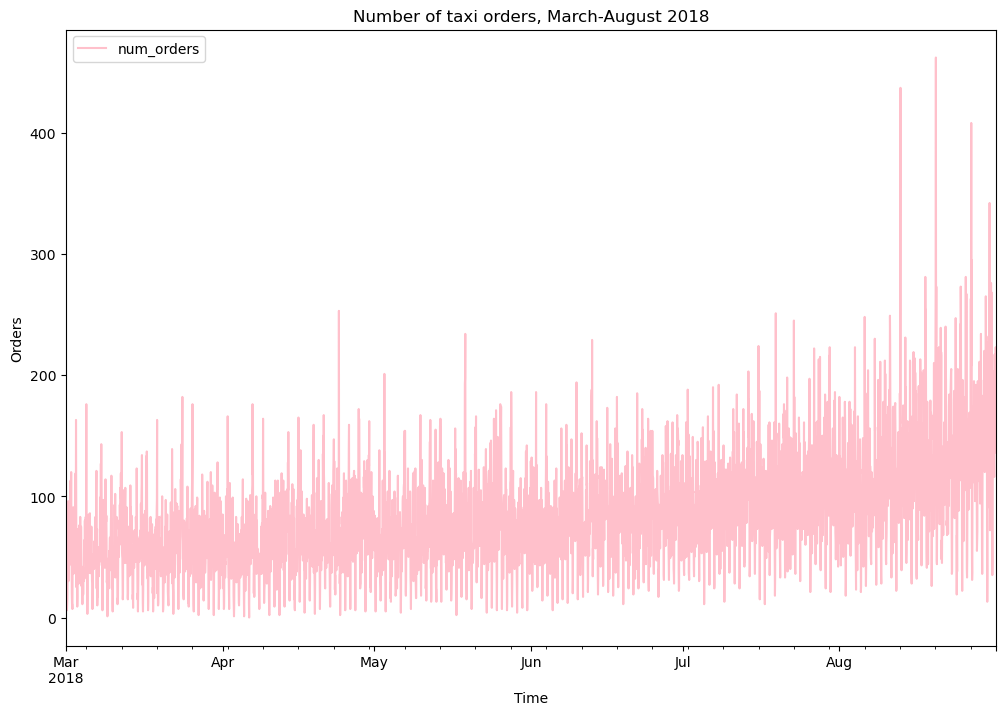

In [11]:
df.plot(color='pink', figsize=(12, 8));
plt.title('Number of taxi orders, March-August 2018')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.show()

The data provided for analysis includes information about the number of taxi trips from March to August 2018. There are no missing values in the data, and it is arranged in chronological order.

After resampling at an hourly frequency, it became apparent that the number of trips increased towards the end of the period compared to the beginning.

## Analysis of Time Series

In [12]:
decomposed = seasonal_decompose(df)

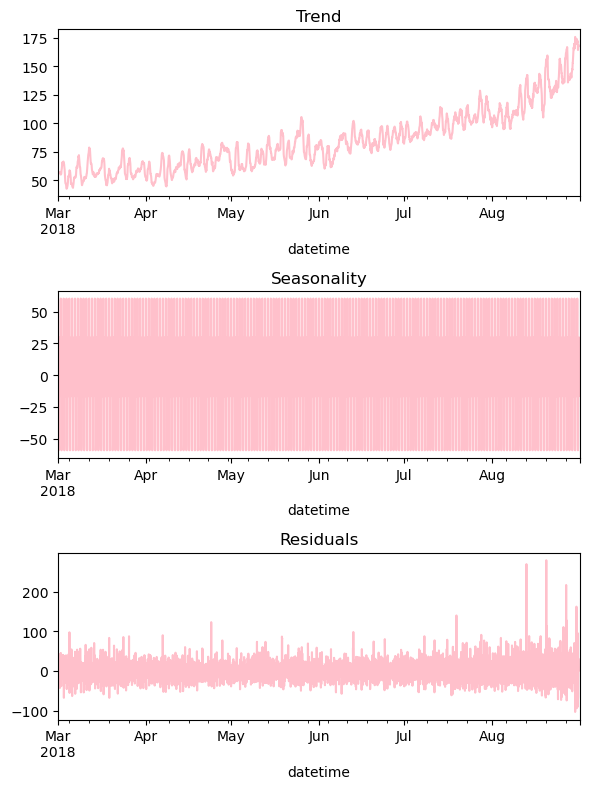

In [13]:
#Building trends, seasonality, and residuals for the entire period
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='pink')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='pink')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='pink')
plt.title('Residuals')
plt.tight_layout()
plt.show()

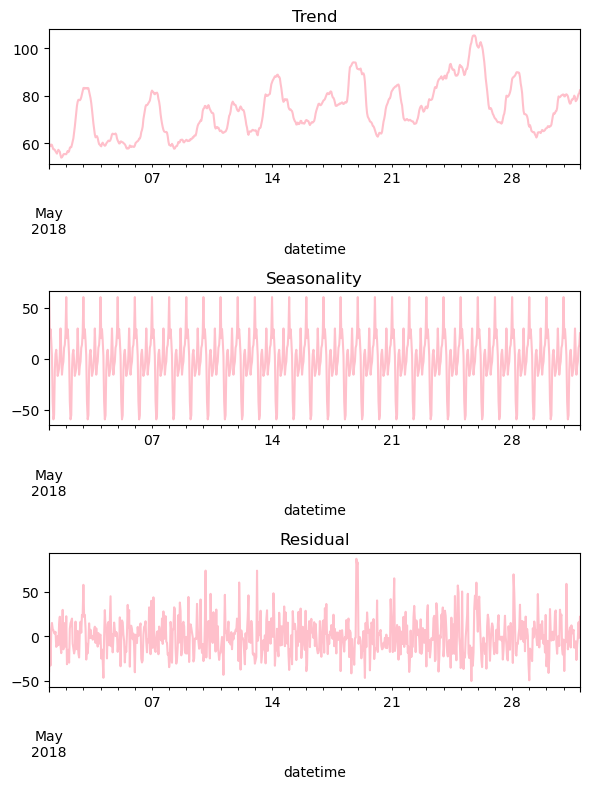

In [14]:
#Building trends, seasonality, and residuals for May
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-05-01':'2018-05-31'].plot(ax=plt.gca(), color='pink')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca(), color='pink')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-31'].plot(ax=plt.gca(), color='pink')
plt.title('Residual')
plt.tight_layout()
plt.show()

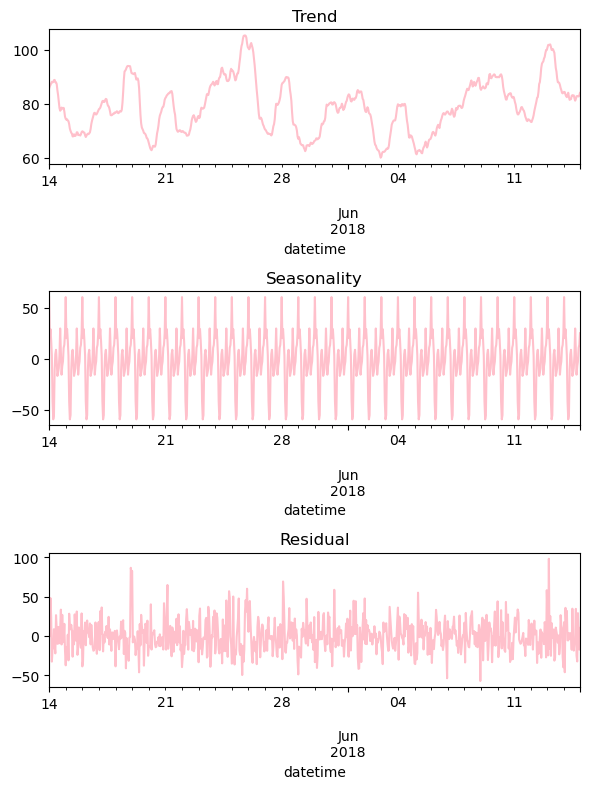

In [15]:
#Building trends, seasonality, and residuals for a week
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-05-14':'2018-06-14'].plot(ax=plt.gca(), color='pink')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-14':'2018-06-14'].plot(ax=plt.gca(), color='pink')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-05-14':'2018-06-14'].plot(ax=plt.gca(), color='pink')
plt.title('Residual')
plt.tight_layout()
plt.show()

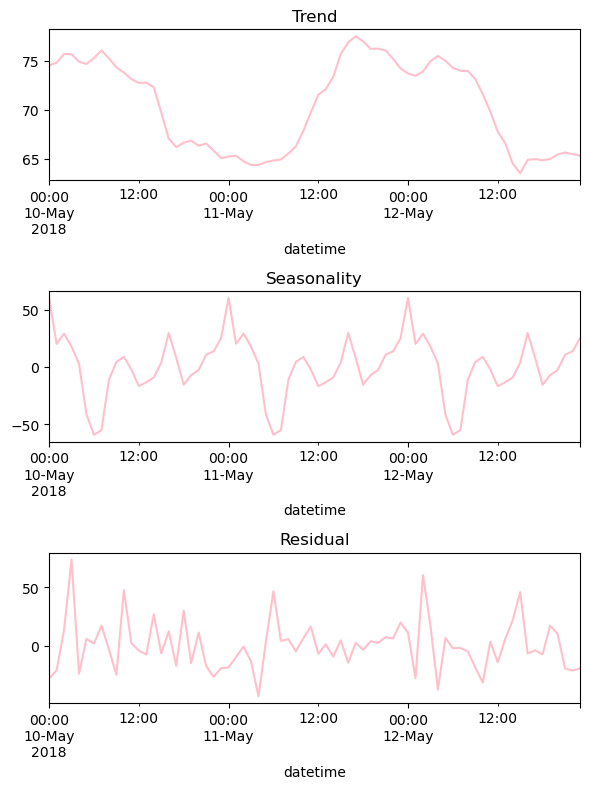

In [16]:
#Building trends, seasonality, and residuals for two days
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-05-10':'2018-05-12'].plot(ax=plt.gca(), color='pink')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-10':'2018-05-12'].plot(ax=plt.gca(), color='pink')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-05-10':'2018-05-12'].plot(ax=plt.gca(), color='pink')
plt.title('Residual')
plt.tight_layout()
plt.show()

In [17]:
data = df.resample('1D').sum()
decomposed = seasonal_decompose(data)

From the graphs, it can be seen that there is a trend of increasing trips over time throughout the entire period. When examining data for a week, it can be observed that the number of trips increases towards Thursday and then reaches its peak on Saturday.

Also, the number of trips increases closer to midnight and decreases during the day.

Now let's check the time series for stationarity using time series differencing.

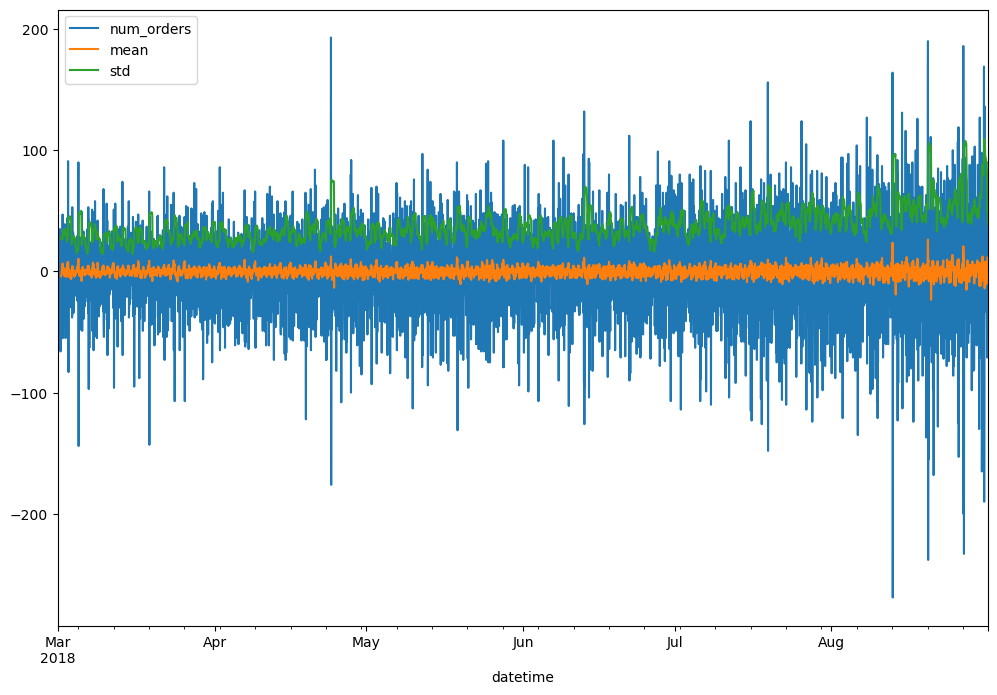

In [18]:
df_stationary = df - df.shift()
df_stationary['mean'] = df_stationary['num_orders'].rolling(15).mean()
df_stationary['std'] = df_stationary['num_orders'].rolling(15).std()
df_stationary.plot(figsize=(12,8));

In [19]:
#Checking the time series for stationarity using the Dickey-Fuller test
result = adfuller(df['num_orders'])
print('ADF-criterion: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
  print('\t {}: {}'.format(key, value))

ADF-criterion: -3.068924289027953
p-value: 0.028940051402613094
Critical values:
	 1%: -3.431842162413052
	 5%: -2.8621993540813637
	 10%: -2.567120978470452


For the test, two hypotheses were set:

 - H0: The series is non-stationary.
 - H1: The series is stationary.
 
The p-value (0.03) is below the threshold of 0.05, which means that the null hypothesis can be rejected, indicating that the series is stationary.

In [20]:
#Creating Features for the Planning Horizon
def making_features(df, max_lag, rolling_mean_size):
    df['weekday'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
making_features(df, 24, 48)

In [22]:
df.dropna(inplace=True)

In [23]:
df.head()

,num_orders,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,5,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4368 non-null   int64  
 1   weekday       4368 non-null   int64  
 2   hour          4368 non-null   int64  
 3   lag_1         4368 non-null   float64
 4   lag_2         4368 non-null   float64
 5   lag_3         4368 non-null   float64
 6   lag_4         4368 non-null   float64
 7   lag_5         4368 non-null   float64
 8   lag_6         4368 non-null   float64
 9   lag_7         4368 non-null   float64
 10  lag_8         4368 non-null   float64
 11  lag_9         4368 non-null   float64
 12  lag_10        4368 non-null   float64
 13  lag_11        4368 non-null   float64
 14  lag_12        4368 non-null   float64
 15  lag_13        4368 non-null   float64
 16  lag_14        4368 non-null   float64
 17  lag_15        4368 non-null

After analyzing the data for trends and seasonality, it became clear that the number of taxi rides increased towards summer, and the count also rises closer to midnight and then decreases towards noon.

Then, it was demonstrated on the graph that the time series is stationary. After that, 27 features were created for further forecasting.

## Model training

In [25]:
dc_train_valid, dc_test = train_test_split(df, shuffle=False, test_size=0.1)
dc_train, dc_valid = train_test_split(dc_train_valid, shuffle=False, test_size=0.1)

dc_features_train = dc_train.drop('num_orders', axis=1)
dc_target_train = dc_train['num_orders']
dc_features_valid = dc_valid.drop('num_orders', axis=1)
dc_target_valid = dc_valid['num_orders']
dc_features_test = dc_test.drop('num_orders', axis=1)
dc_target_test = dc_test['num_orders']


print('Training set:', dc_train.shape[0] / df.shape[0] * 100)
print('Validation set:', dc_valid.shape[0] / df.shape[0] * 100)
print('Test set:', dc_test.shape[0] / df.shape[0] * 100)

Training set: 80.97527472527473
Validation set: 9.02014652014652
Test set: 10.004578754578755


### Linear Regression

In [26]:
lin_model = LinearRegression()
lin_model.fit(dc_features_train, dc_target_train)
lin_pred = lin_model.predict(dc_features_valid)
lin_rmse = np.sqrt(mean_squared_error(dc_target_valid, lin_pred))
print('RMSE for Linear Regression:', lin_rmse)

RMSE for Linear Regression: 33.998008127920706


### Decision Tree

In [27]:
pipeline_tree = Pipeline(
    [('dtree', DecisionTreeRegressor(random_state=RANDOM_STATE))])

parameters_tree = {
    'dtree__max_depth': range(5, 50, 10),
    'dtree__min_samples_split': [2, 3, 4],
    'dtree__min_samples_leaf': [1, 4, 8]
}

gs_tree = RandomizedSearchCV(pipeline_tree, parameters_tree, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gs_tree.fit(dc_features_train, dc_target_train)
pred_tree = gs_tree.best_estimator_.predict(dc_features_valid)

rmse_tree = np.sqrt(mean_squared_error(dc_target_valid, pred_tree))

print(f'RMSE for Decision Tree is: {rmse_tree}')
print(f'The best parameters: {gs_tree.best_params_}')

RMSE for Decision Tree is: 38.49064617896591
The best parameters: {'dtree__min_samples_split': 3, 'dtree__min_samples_leaf': 4, 'dtree__max_depth': 5}


### Random Forest

In [28]:
pipeline_forest = Pipeline(
    [('dforest', RandomForestRegressor(random_state=RANDOM_STATE))])

parameters_forest = {
    'dforest__n_estimators': range(50, 251, 50),
    'dforest__max_depth': range(2, 20),
    'dforest__min_samples_split': (2, 3, 4),
    'dforest__min_samples_leaf': (1, 2, 3, 4)
}

gs_forest = RandomizedSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gs_forest.fit(dc_features_train, dc_target_train)
pred_forest = gs_forest.best_estimator_.predict(dc_features_valid)

rmse_forest = np.sqrt(mean_squared_error(dc_target_valid, pred_forest))

print(f'RMSE for Random Forest is: {rmse_forest}')
print(f'The best parameters: {gs_forest.best_params_}')

RMSE for Random Forest is: 31.36708441120137
The best parameters: {'dforest__n_estimators': 200, 'dforest__min_samples_split': 4, 'dforest__min_samples_leaf': 2, 'dforest__max_depth': 18}


### CatBoost

In [29]:
pipeline_catboost = Pipeline(
    [('dcat', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])

parameters_catboost = {
    'dcat__iterations': np.arange(100, 1000, 100),  
    'dcat__learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'dcat__depth': np.arange(3, 11),  
    'dcat__l2_leaf_reg': [1, 3, 5, 7], 
}

gs_catboost = RandomizedSearchCV(pipeline_catboost, parameters_catboost, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
gs_catboost.fit(dc_features_train, dc_target_train)
pred_catboost = gs_catboost.best_estimator_.predict(dc_features_valid)

rmse_catboost = np.sqrt(mean_squared_error(dc_target_valid, pred_catboost))

print(f'RMSE for CatBoost is: {rmse_catboost}')
print(f'The best parameters: {gs_catboost.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE for CatBoost is: 30.637155302385445
The best parameters: {'dcat__learning_rate': 0.05, 'dcat__l2_leaf_reg': 3, 'dcat__iterations': 300, 'dcat__depth': 6}


### XGBoost

In [30]:
pipeline_xgboost = Pipeline([
    ('xgboost', XGBRegressor(random_state=RANDOM_STATE, verbosity=0))
])

parameters_xgboost = {
    'xgboost__n_estimators': range(50, 251, 50),
    'xgboost__max_depth': range(2, 20),
    'xgboost__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

gs_xgboost = RandomizedSearchCV(pipeline_xgboost, parameters_xgboost, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
gs_xgboost.fit(dc_features_train, dc_target_train)
pred_xgboost = gs_xgboost.best_estimator_.predict(dc_features_valid)

rmse_xgboost = np.sqrt(mean_squared_error(dc_target_valid, pred_xgboost))

print(f'RMSE for XGBoost is: {rmse_xgboost}')
print(f'The best parameters: {gs_xgboost.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE for XGBoost is: 31.065866069523693
The best parameters: {'xgboost__n_estimators': 200, 'xgboost__max_depth': 5, 'xgboost__learning_rate': 0.05}


In [31]:
results = pd.DataFrame(
    [lin_rmse, 
     rmse_tree,
     rmse_forest,
     rmse_catboost,
     rmse_xgboost], 
    index=['Linear regression', 'Decision tree', 'Random Forest', 'CatBoost Regressor', 'XGBoost Regressor'], 
    columns=['RMSE']
)
results.sort_values(by='RMSE')

,RMSE
CatBoost Regressor,30.637155
XGBoost Regressor,31.065866
Random Forest,31.367084
Linear regression,33.998008
Decision tree,38.490646


The model with the lowest RMSE score is CatBoostRegressor, so let's test it on the test set.

## Model testing

In [35]:
pred_catboost_test = gs_catboost.best_estimator_.predict(dc_features_test)

rmse_catboost_test = np.sqrt(mean_squared_error(dc_target_test, pred_catboost_test))

print(f'RMSE is: {rmse_catboost_test}')

RMSE is: 49.7294075921551


In [36]:
pred_xgboost_test = gs_xgboost.best_estimator_.predict(dc_features_test)

rmse_xgboost_test = np.sqrt(mean_squared_error(dc_target_test, pred_xgboost_test))

print(f'RMSE is: {rmse_xgboost_test}')

RMSE is: 46.63210648169954
[CV 1/3] END dcat__depth=6, dcat__iterations=300, dcat__l2_leaf_reg=3, dcat__learning_rate=0.05;, score=-419.929 total time=   4.8s
[CV 2/3] END dcat__depth=6, dcat__iterations=300, dcat__l2_leaf_reg=3, dcat__learning_rate=0.05;, score=-475.082 total time=   4.1s
[CV 3/3] END dcat__depth=6, dcat__iterations=300, dcat__l2_leaf_reg=3, dcat__learning_rate=0.05;, score=-731.014 total time=   3.7s
[CV 2/3] END dcat__depth=4, dcat__iterations=600, dcat__l2_leaf_reg=3, dcat__learning_rate=0.1;, score=-480.091 total time=   4.1s
[CV 1/3] END dcat__depth=3, dcat__iterations=300, dcat__l2_leaf_reg=1, dcat__learning_rate=0.01;, score=-503.193 total time=   1.8s
[CV 2/3] END dcat__depth=3, dcat__iterations=300, dcat__l2_leaf_reg=1, dcat__learning_rate=0.01;, score=-571.976 total time=   2.0s
[CV 3/3] END dcat__depth=3, dcat__iterations=300, dcat__l2_leaf_reg=1, dcat__learning_rate=0.01;, score=-915.998 total time=   1.7s
[CV 1/3] END dcat__depth=5, dcat__iterations=200, 

The model showed worse result on the test set comparing to the training and validation sets, which suggests that the model is overfitting. Also, the RMSE value is bigger then requested (49.729 vs 48)

Therefore, testing was conducted on the XGBoost model with, which had the next lowest RMSE on the training set. Test value 46.632, which is also larger than the training result. However, the end result is lower than the value asked, therefore, model still can be applied in the business.

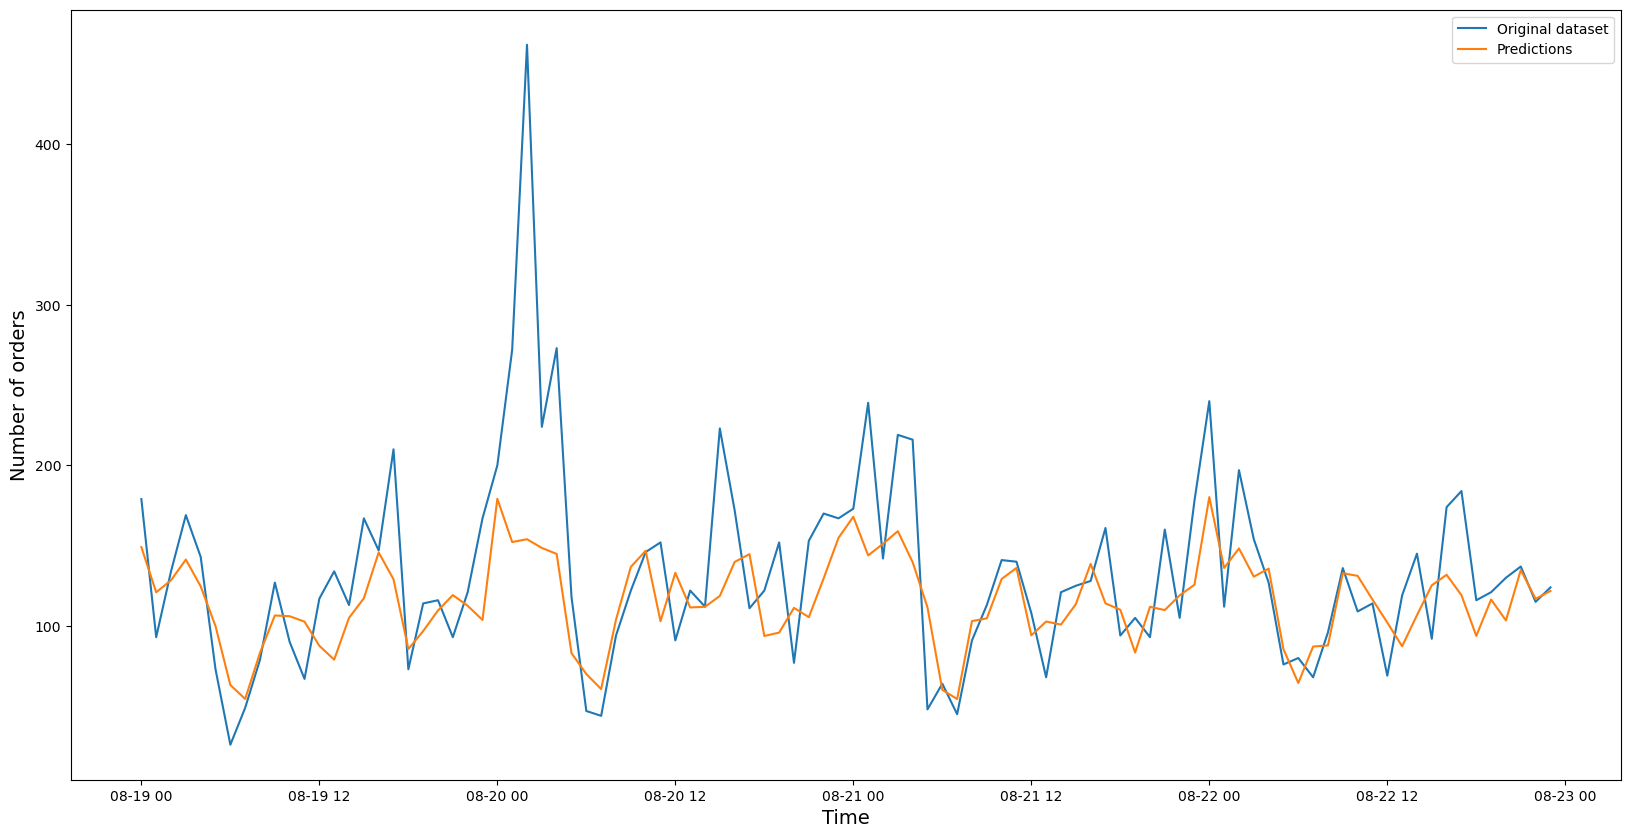

In [37]:
catboost_pred_df = pd.DataFrame(pred_xgboost_test, index=dc_features_test.index, columns=['pred'])

start_date = '2018-08-19'
end_date = '2018-08-22'
subset_data = dc_features_test.loc[start_date:end_date]

plt.figure(figsize=(20,10))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.plot(subset_data.index, dc_target_test.loc[start_date:end_date], label='Original dataset')
plt.plot(subset_data.index, catboost_pred_df.loc[start_date:end_date, 'pred'], label='Predictions')
plt.legend()
plt.show()

From the prediction plot and the original values, it is evident that the model makes predictions with a similar trend but does not precisely match some values, especially during peak hours.

## Вывод

The analysis was based on data about the number of taxi rides from March to August 2018. The goal of the project was to build a model to predict the number of taxi orders for the next hour to attract more drivers during peak hours.

Data analysis on trends and seasonality revealed that the number of rides increases towards the summer and grows closer to midnight, followed by a decline towards noon. The graph demonstrated that the time series is stationary. Subsequently, 27 features were created for further forecasting.

Four models were trained: linear regression, decision tree, random forest, CatBoost, and XGBoost. The best result was achieved by the CatBoost model (30.637 on the training set and 45.72 on the test set). Nevertheless, the model performed worse on the test set due to overfitting. Consequently, XGBoost was tested as well and got better results with lower than threshold value, so the XGBoost model is recommended for the business implementation.